In [74]:
import requests
import pandas as pd
import requests
import json

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import plotly.express as px
import plotly.io as pio
from datetime import datetime

In [19]:
def read_credentials(file_path):
  """Reads Strava credentials from a JSON file."""
  with open(file_path, 'r') as f:
    data = json.load(f)
  return data

In [27]:
credentials_file = "/Users/xueyishu/Downloads/my_strava_credentials.json"
credentials = read_credentials(credentials_file)

In [28]:
my_client_id = credentials['client_id']
my_client_secret = credentials['client_secret']

In [ ]:
redirect_uri = "http://localhost/exchange_token"  # This can be any valid URL

# Step 1: Get the authorization URL
auth_url = f"https://www.strava.com/oauth/authorize?client_id={client_id}&response_type=code&redirect_uri={redirect_uri}&approval_prompt=force&scope=read,activity:read"

print(f"Go to this URL to authorize: {auth_url}")

In [ ]:
# Step 2: Exchange the authorization code for an access token
code = input("Enter the code you received: ")

In [8]:
token_url = 'https://www.strava.com/oauth/token'
payload = {
    'client_id': client_id,
    'client_secret': client_secret,
    'code': code,
    'grant_type': 'authorization_code'
}

response = requests.post(token_url, data=payload)
token_data = response.json()

access_token = token_data['access_token']
refresh_token = token_data['refresh_token']

In [29]:
def get_recent_activities(access_token, num_activities):
    headers = {
        'Authorization': f'Bearer {access_token}'
    }

    activities_url = "https://www.strava.com/api/v3/athlete/activities"
    params = {
        'per_page': num_activities,  # Number of activities to fetch
        'page': 10                    # Page number
    }

    response = requests.get(activities_url, headers=headers, params=params)
    activities = response.json()

    return activities

In [30]:
recent_200_activities = get_recent_activities(access_token, 200)

In [31]:
df = pd.DataFrame(recent_200_activities)

In [56]:
palette_set3 = ['#8dd3c7', '#ffffb3', '#bebada', '#fb8072', 
                '#80b1d3', '#fdb462', '#b3de69', '#fccde5', 
                '#d9d9d9', '#bc80bd']

In [63]:
# Convert start_date to datetime format
df["start_date_local"] = pd.to_datetime(df["start_date_local"])

# Extract year and month
df["year_month"] = df["start_date_local"].dt.to_period("M")
df["week"] = df["start_date_local"].dt.to_period("W")

def plot_by_agg_period(data, period_col):
    # Group by year_month and type, then sum the moving time and convert to hours
    grouped_df = data.groupby([period_col, "type"])["moving_time"].sum().reset_index()
    grouped_df["moving_time"] = grouped_df["moving_time"] / 3600  # Convert seconds to hours

    # Pivot table to have types as columns and months as rows
    pivot_df = grouped_df.pivot(
        index=period_col, columns="type", values="moving_time"
    ).fillna(0)
    
    # Plotting
    pivot_df.plot(
        kind="bar", stacked=True, figsize=(12, 8), color=palette_set3, edgecolor="black"
    )

    plt.title("Total Exercise Time by Type")
    plt.xlabel("")
    plt.ylabel("Exercise Time (hours)")
    plt.xticks(rotation=45)
    plt.grid(axis="y")
    
    # Move the legend outside of the plot
    plt.legend(title="Exercise Type", bbox_to_anchor=(1.05, 1), loc="upper left")
    
    # Display the plot
    plt.show()


/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_1121/1512945737.py:5: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["year_month"] = df["start_date_local"].dt.to_period("M")
/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_1121/1512945737.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["week"] = df["start_date_local"].dt.to_period("W")


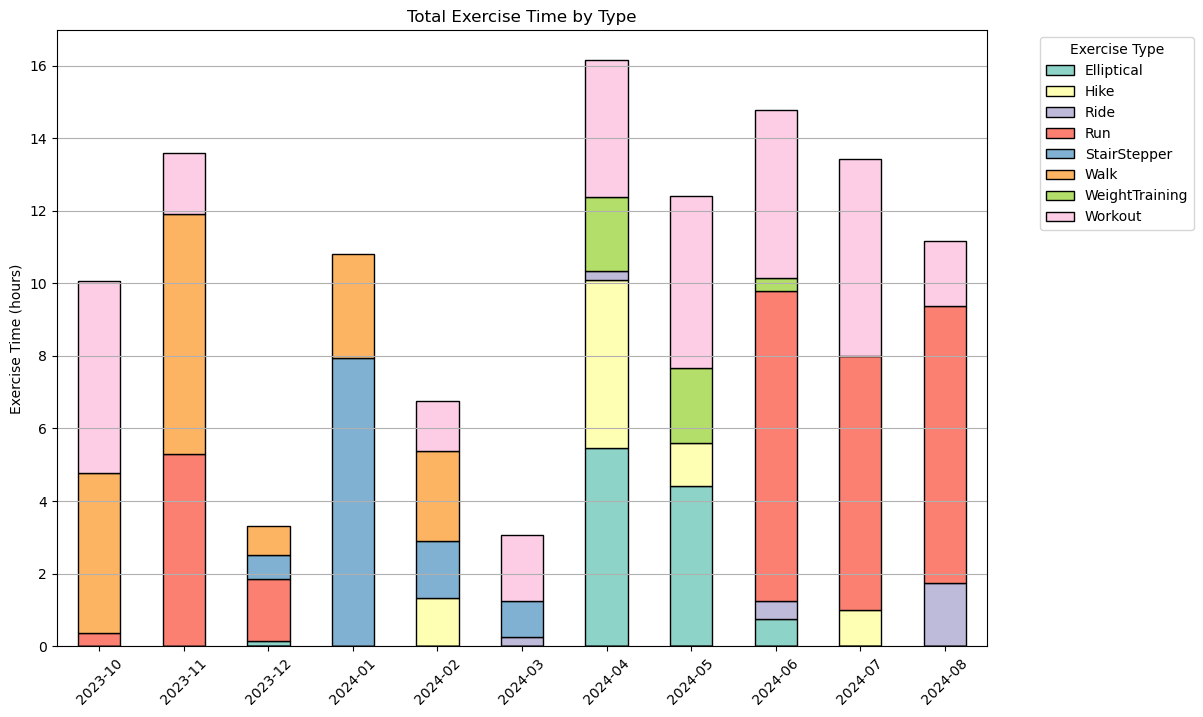

In [64]:
plot_by_agg_period(df, "year_month")

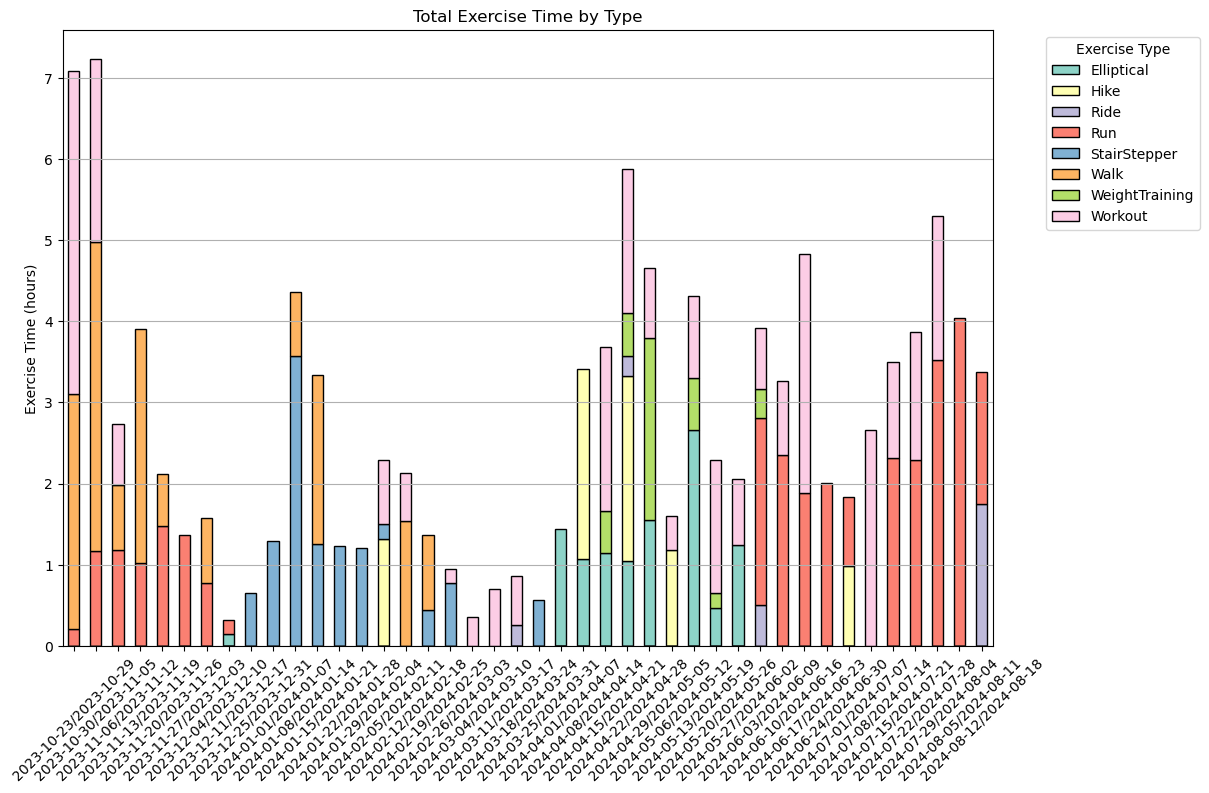

In [65]:
plot_by_agg_period(df, "week")

In [67]:
# Ensure that the 'start_date_local' and 'elapsed_time' columns are in the correct format
df['start_date_local'] = pd.to_datetime(df['start_date_local'])

In [73]:
# Convert moving_time from seconds to hours
df["time_spent_hours"] = df["moving_time"] / 3600

# Convert distance from meters to miles
df["distance_miles"] = df["distance"] * 0.000621371

# Group by week
df["week"] = df["start_date"].dt.to_period("W").apply(lambda r: r.start_time)

weekly_time = df.groupby(["week", "sport_type"])["time_spent_hours"].sum().reset_index()
weekly_distance = (
    df[df["sport_type"] == "Run"].groupby("week")["distance_miles"].sum().reset_index()
)

# Group by month
df["month"] = df["start_date"].dt.to_period("M").apply(lambda r: r.start_time)

monthly_time = (
    df.groupby(["month", "sport_type"])["time_spent_hours"].sum().reset_index()
)
monthly_distance = (
    df[df["sport_type"] == "Run"].groupby("month")["distance_miles"].sum().reset_index()
)

# Plotting with Plotly
fig_weekly_time = px.bar(
    weekly_time,
    x="week",
    y="time_spent_hours",
    color="sport_type",
    title="Time Spent on Activities by Week",
    labels={"time_spent_hours": "Hours", "week": "Week"},
)

fig_monthly_time = px.bar(
    monthly_time,
    x="month",
    y="time_spent_hours",
    color="sport_type",
    title="Time Spent on Activities by Month",
    labels={"time_spent_hours": "Hours", "month": "Month"},
)

fig_weekly_distance = px.bar(
    weekly_distance,
    x="week",
    y="distance_miles",
    title="Running Distance by Week",
    labels={"distance_miles": "Distance (Miles)", "week": "Week"},
)

fig_monthly_distance = px.bar(
    monthly_distance,
    x="month",
    y="distance_miles",
    title="Running Distance by Month",
    labels={"distance_miles": "Distance (Miles)", "month": "Month"},
)

HTML file 'strava_analysis.html' created with plots.


/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_1121/2915027501.py:8: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.

/var/folders/1t/hn2sdwfn1lx9rcvb_mkfkqz00000gn/T/ipykernel_1121/2915027501.py:14: UserWarning:

Converting to PeriodArray/Index representation will drop timezone information.



In [ ]:
# Save to HTML file
with open('strava_analysis.html', 'w') as f:
    f.write(fig_weekly_time.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_monthly_time.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_weekly_distance.to_html(full_html=False, include_plotlyjs='cdn'))
    f.write(fig_monthly_distance.to_html(full_html=False, include_plotlyjs='cdn'))

print("HTML file 'strava_analysis.html' created with plots.")